# Usage

This notebook runs through using the dye score library and methodology to score scripts.

The input data is generated by OpenWPM. A dataset that has been used with the dye score is available at github.com/mozilla/overscripted

This notebook was run on a small sample.

Dye Score expects a spark context to be available for thie initial data processing steps.

Additionally, set-up a Dask Client however you choose to. The below cell was generated by Dask's JupyterLab extension. 

Note the warning is known by the dask team (https://github.com/dask/distributed/issues/2564).

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:32829")
client

/home/bird/miniconda3/envs/ovscrptd/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/bird/miniconda3/envs/ovscrptd/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Client Scheduler: tcp://127.0.0.1:32829 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 33.35 GB


In [2]:
import dask.dataframe as dd
import numpy as np

from dye_score import DyeScore

In [3]:
ds = DyeScore('config.yaml', print_config=False)

In [4]:
ds.validate_input_data()

True

In [5]:
df = ds.get_input_df()
df.head()

,top_level_url,script_url,func_name,symbol
0,https://7ero.org/,https://forsiteid6346.tech/convert/scripts/cre...,b.exec,CanvasRenderingContext2D.fillStyle
1,https://www.stevinsonhyundai.com/,https://tag.contactatonce.com/le_secure_storag...,r,window.Storage.setItem
2,https://www.thecircle.com/us/,https://www.thecircle.com/k3/ruxitagentjs_ICA2...,fc,window.document.cookie
3,https://www.jcpportraits.com/,https://cdn.optimizely.com/js/8447592883.js,be/<,window.Storage.length
4,https://www.technik-profis.de/,https://cdn.optimizely.com/js/8323142798.js,t.getUserAgent,window.navigator.userAgent


In [6]:
print(f'This sample is {len(df):,} rows')

This sample is 2,312,697 rows


## Data Preparation

In [7]:
%time ds.build_raw_snippet_df()

                       top_level_url  \
0                  https://7ero.org/   
1  https://www.stevinsonhyundai.com/   
2      https://www.thecircle.com/us/   
3      https://www.jcpportraits.com/   
4     https://www.technik-profis.de/   

                                          script_url       func_name  \
0  https://forsiteid6346.tech/convert/scripts/cre...          b.exec   
1  https://tag.contactatonce.com/le_secure_storag...               r   
2  https://www.thecircle.com/k3/ruxitagentjs_ICA2...              fc   
3        https://cdn.optimizely.com/js/8447592883.js            be/<   
4        https://cdn.optimizely.com/js/8323142798.js  t.getUserAgent   

                               symbol  \
0  CanvasRenderingContext2D.fillStyle   
1              window.Storage.setItem   
2              window.document.cookie   
3               window.Storage.length   
4          window.navigator.userAgent   

                                         raw_snippet  called  
0  forsiteid6346

'/home/bird/Dev/mozilla/overscripted-clustering/new_data_dye_package/test_dyescore_data/raw_snippet_call_df.parquet'

In [8]:
%time ds.build_snippet_map()

                                         raw_snippet              snippet
0  forsiteid6346.tech||createjs-2015.11.26.min.js...   792826184637634903
1  tag.contactatonce.com||storage.secure.min.html||r -3182365903651065472
2  www.thecircle.com||ruxitagentjs_ICA27SVfhjoqrx... -9027005229756292155
3            cdn.optimizely.com||8447592883.js||be/<  2248811367515630966
4  cdn.optimizely.com||8323142798.js||t.getUserAgent -6265856453346281252
CPU times: user 81 ms, sys: 10.6 ms, total: 91.6 ms
Wall time: 1.71 s


'/home/bird/Dev/mozilla/overscripted-clustering/new_data_dye_package/test_dyescore_data/snippet_lookup.parquet'

In [9]:
%time ds.build_snippets(spark)

/home/bird/miniconda3/envs/ovscrptd/lib/python3.6/site-packages/pyarrow/__init__.py:159: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


Dataset has 216 unique symbols
<xarray.DataArray (snippet: 231057, symbol: 216)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * snippet  (snippet) object '-1000043381057326421' ... '999736522860943363'
  * symbol   (symbol) object 'AnalyserNode.channelCount' ... 'window.sessionStorage'
CPU times: user 13.6 s, sys: 859 ms, total: 14.5 s
Wall time: 4min


'/home/bird/Dev/mozilla/overscripted-clustering/new_data_dye_package/test_dyescore_data/snippets.zarr'

In [12]:
%time ds.build_snippet_snippet_dyeing_map(spark)

CPU times: user 39.1 ms, sys: 51.7 ms, total: 90.8 ms
Wall time: 9.8 s


'/home/bird/Dev/mozilla/overscripted-clustering/new_data_dye_package/test_dyescore_data/snippet_dyeing_map.parquet'

## Dyeing

Building list of dye snippets is up to user. Here we show an example using a keyword search for `fingerprint`.

In [4]:
snippet_dyeing_map_file = ds.dye_score_data_file('snippet_dyeing_map')
snippet_data = dd.read_parquet(snippet_dyeing_map_file, engine='pyarrow')
snippet_data.head()

,top_level_url,script_url,func_name,snippet,clean_script
0,http://narvalife.ucoz.net/,https://usocial.pro/usocial/fingerprint2.min.js,e.prototype.getNavigatorPlatform,4996125033026346492,usocial.pro/usocial/fingerprint2.min.js
1,https://sletaem.by/,https://sletaem.by/,updateTimer,-6846198680163094774,sletaem.by/
2,http://realcoco.com/,http://fs.bizspring.net/fsn/bstrk.1.js,_trkdp_getCookie,2578583411096044764,fs.bizspring.net/fsn/bstrk.1.js
3,https://www.trendydiscount.shop/,https://www.google-analytics.com/analytics.js,zc,1695113790766404014,www.google-analytics.com/analytics.js
4,https://www.liveaquaria.com/,https://www.youtube.com/yts/jsbin/player-vflYg...,hE,2066756695033721030,www.youtube.com/yts/jsbin/player-vflYgf3QU/en_...


In [4]:
key = 'fingerprint'
filename_suffix = f'{key}_keyword'
thresholds = [0.15, 0.2, 0.23, 0.24, 0.25, 0.26, 0.3, 0.35]

In [6]:
script_snippets = snippet_data[snippet_data.clean_script.str.contains(key, case=False)].snippet.unique().astype(str)
funcname_snippets = snippet_data[snippet_data.func_name.str.contains(key, case=False)].snippet.unique().astype(str)
dye_snippets = np.unique(np.append(script_snippets, funcname_snippets))

With the dye snippets in hand we can now use the DyeScore library to compute the dye scores for a range of thresholds.

In [8]:
%time ds.compute_distances_for_dye_snippets(dye_snippets=dye_snippets, filename_suffix=filename_suffix)

/home/bird/miniconda3/envs/ovscrptd/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


<xarray.DataArray 'data' (snippet: 231057, dye_snippet: 553)>
dask.array<shape=(231057, 553), dtype=float64, chunksize=(10000, 100)>
Coordinates:
  * snippet      (snippet) object '-1000043381057326421' ... '999736522860943363'
  * dye_snippet  (dye_snippet) object '-1006661115172174629' ... '917589267078160730'
CPU times: user 453 ms, sys: 120 ms, total: 573 ms
Wall time: 1min 6s


'/home/bird/Dev/mozilla/overscripted-clustering/new_data_dye_package/test_dyescore_results/snippets_dye_distances_from_fingerprint_keyword'

In [9]:
%time ds.compute_snippets_scores_for_thresholds(thresholds, filename_suffix=filename_suffix)

CPU times: user 1.55 s, sys: 253 ms, total: 1.8 s
Wall time: 13.1 s


['/home/bird/Dev/mozilla/overscripted-clustering/new_data_dye_package/test_dyescore_results/snippets_score_from_fingerprint_keyword_0.15',
 '/home/bird/Dev/mozilla/overscripted-clustering/new_data_dye_package/test_dyescore_results/snippets_score_from_fingerprint_keyword_0.2',
 '/home/bird/Dev/mozilla/overscripted-clustering/new_data_dye_package/test_dyescore_results/snippets_score_from_fingerprint_keyword_0.23',
 '/home/bird/Dev/mozilla/overscripted-clustering/new_data_dye_package/test_dyescore_results/snippets_score_from_fingerprint_keyword_0.24',
 '/home/bird/Dev/mozilla/overscripted-clustering/new_data_dye_package/test_dyescore_results/snippets_score_from_fingerprint_keyword_0.25',
 '/home/bird/Dev/mozilla/overscripted-clustering/new_data_dye_package/test_dyescore_results/snippets_score_from_fingerprint_keyword_0.26',
 '/home/bird/Dev/mozilla/overscripted-clustering/new_data_dye_package/test_dyescore_results/snippets_score_from_fingerprint_keyword_0.3',
 '/home/bird/Dev/mozilla/over

In [5]:
%time ds.compute_dye_scores_for_thresholds(thresholds, filename_suffix=filename_suffix)

CPU times: user 10.3 s, sys: 415 ms, total: 10.7 s
Wall time: 57 s


['/home/bird/Dev/mozilla/overscripted-clustering/new_data_dye_package/test_dyescore_results/dye_score_from_fingerprint_keyword_0.15.csv.gz',
 '/home/bird/Dev/mozilla/overscripted-clustering/new_data_dye_package/test_dyescore_results/dye_score_from_fingerprint_keyword_0.2.csv.gz',
 '/home/bird/Dev/mozilla/overscripted-clustering/new_data_dye_package/test_dyescore_results/dye_score_from_fingerprint_keyword_0.23.csv.gz',
 '/home/bird/Dev/mozilla/overscripted-clustering/new_data_dye_package/test_dyescore_results/dye_score_from_fingerprint_keyword_0.24.csv.gz',
 '/home/bird/Dev/mozilla/overscripted-clustering/new_data_dye_package/test_dyescore_results/dye_score_from_fingerprint_keyword_0.25.csv.gz',
 '/home/bird/Dev/mozilla/overscripted-clustering/new_data_dye_package/test_dyescore_results/dye_score_from_fingerprint_keyword_0.26.csv.gz',
 '/home/bird/Dev/mozilla/overscripted-clustering/new_data_dye_package/test_dyescore_results/dye_score_from_fingerprint_keyword_0.3.csv.gz',
 '/home/bird/De

## Evaluate scores

We now manually review the dye scores compared to the input dye list in order to select the best distance threshold.

The review process needs a list of `clean script` scripts to compare to the dye score list to produce the following plot. The production of this list will be dependent on how the dye snippets list was prepared. 

In [10]:
import pandas as pd

from bokeh.io import export_png, show
from bokeh.layouts import gridplot
from dye_score.plotting import get_pr_plot
from IPython.display import Image

In [8]:
snippet_data.head()

,top_level_url,script_url,func_name,snippet,clean_script
0,http://narvalife.ucoz.net/,https://usocial.pro/usocial/fingerprint2.min.js,e.prototype.getNavigatorPlatform,4996125033026346492,usocial.pro/usocial/fingerprint2.min.js
1,https://sletaem.by/,https://sletaem.by/,updateTimer,-6846198680163094774,sletaem.by/
2,http://realcoco.com/,http://fs.bizspring.net/fsn/bstrk.1.js,_trkdp_getCookie,2578583411096044764,fs.bizspring.net/fsn/bstrk.1.js
3,https://www.trendydiscount.shop/,https://www.google-analytics.com/analytics.js,zc,1695113790766404014,www.google-analytics.com/analytics.js
4,https://www.liveaquaria.com/,https://www.youtube.com/yts/jsbin/player-vflYg...,hE,2066756695033721030,www.youtube.com/yts/jsbin/player-vflYgf3QU/en_...


In [9]:
compare_list = snippet_data[snippet_data.snippet.isin(dye_snippets)].clean_script.unique().compute()
compare_list.head()

0              usocial.pro/usocial/fingerprint2.min.js
1    script.hotjar.com/modules-ab5ba0ccf53ded68dfc9...
2                   www.convertthepdf.co/js/landing.js
3     track.adabra.com/sbn_fingerprint.v1.16.47.min.js
4    www.bestwestern.com.br/modules/mod_rewards_but...
Name: clean_script, dtype: object

In [10]:
%time plot_df_paths = ds.build_plot_data_for_thresholds(compare_list, thresholds, filename_suffix=filename_suffix)

CPU times: user 39.7 s, sys: 148 ms, total: 39.9 s
Wall time: 39.9 s


In [7]:
plot_df_paths[0]

'/home/bird/Dev/mozilla/overscripted-clustering/new_data_dye_package/test_dyescore_results/dye_score_plot_data_from_fingerprint_keyword_0.15.csv.gz'

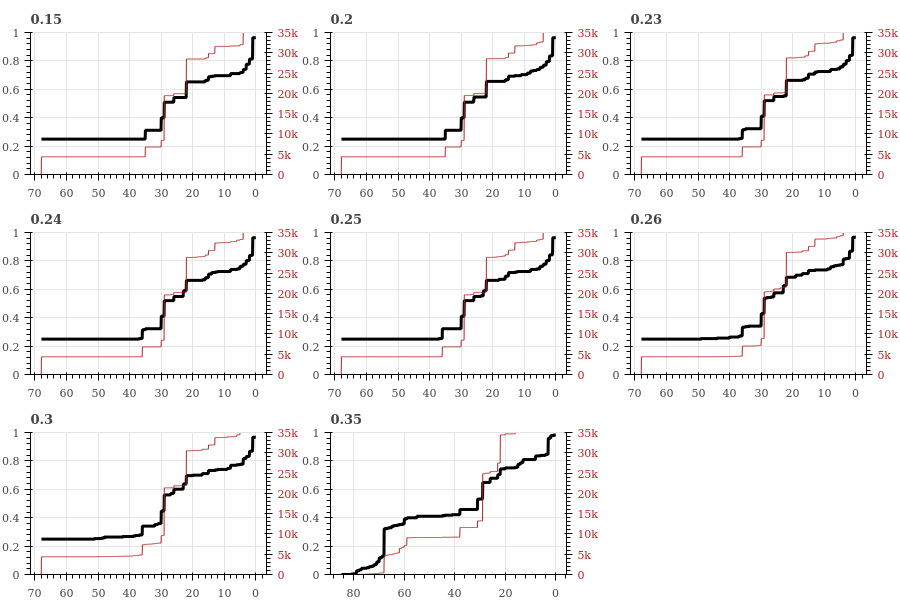

In [11]:
plots = []
plot_opts = dict(tools='', toolbar_location=None, width=300, height=200)
for threshold, pr_df_path in zip(thresholds, plot_df_paths):
    pr_df = pd.read_csv(pr_df_path)
    plots.append(get_pr_plot(pr_df,  title=f'{threshold}', plot_opts=plot_opts))
Image(export_png(gridplot(plots, ncols=3, toolbar_location=None)))

Remaining analysis is up to user based on their preferred distance threshold.